# Загрузка данных

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Устройство: {device}")
if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name()}")

d:\PythonProjects\CV\Laba1\.venv\Lib\site-packages\albumentations\check_version.py:147: UserWarning: Error fetching version info The read operation timed out
  data = fetch_version_info()


Устройство: cuda
GPU: NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [2]:
class CarvanaDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform

        jpg_files = [f for f in os.listdir(images_dir) if f.lower().endswith(".jpg")]
        self.filenames = []
        for f in jpg_files:
            stem = f[:-4]
            mask_path = os.path.join(masks_dir, f"{stem}_mask.png")
            if os.path.isfile(mask_path):
                self.filenames.append(stem)
        print(f"Загружено {len(self.filenames)} пар (из {len(jpg_files)} изображений)")

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        img_path = os.path.join(self.images_dir, f"{fname}.jpg")
        mask_path = os.path.join(self.masks_dir, f"{fname}_mask.png")

        try:
            image = Image.open(img_path).convert("RGB") 
            image = np.array(image) 
        except Exception as e:
            raise RuntimeError(f"Не удалось загрузить изображение {img_path}: {e}")

        try:
            mask = Image.open(mask_path).convert("L") 
            mask = np.array(mask)
            mask = (mask > 127).astype(np.uint8) 
        except Exception as e:
            raise RuntimeError(f"Не удалось загрузить маску {mask_path}: {e}")

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]  
            mask = augmented["mask"]  
        else:
            image = image.astype(np.uint8)
            mask = mask.astype(np.uint8)

        return {
            "image": image, 
            "mask": mask,   
            "fname": fname
        }

In [3]:
IMG_DIR = "data/carvana-image-masking-challenge/train_hq/train_hq"
MASK_DIR = "data/carvana-image-masking-challenge/train_masks/train_masks_png"

In [4]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=5, p=0.2),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

d:\PythonProjects\CV\Laba1\.venv\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [5]:
full_dataset = CarvanaDataset(IMG_DIR, MASK_DIR, transform=None)
print(full_dataset)

Загружено 5088 пар (из 5088 изображений)


In [6]:
car_ids = [fname.split("_")[0] for fname in full_dataset.filenames[:3000]]
unique_ids = list(set(car_ids))
train_ids, temp_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

In [7]:
id_to_idx = {}
for i, fname in enumerate(full_dataset.filenames[:3000]):
    car_id = fname.split("_")[0]
    id_to_idx.setdefault(car_id, []).append(i)

In [8]:
train_idx = [i for cid in train_ids for i in id_to_idx[cid]]
val_idx = [i for cid in val_ids for i in id_to_idx[cid]]
test_idx = [i for cid in test_ids for i in id_to_idx[cid]]

In [9]:
print(f"train={len(train_idx)}, val={len(val_idx)}, test={len(test_idx)}")

train=2392, val=304, test=304


In [10]:
class TransformDataset:
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, idx):
        item = self.subset[idx]
        if self.transform:
            aug = self.transform(image=item["image"], mask=item["mask"])
            return {
                "image": aug["image"],     
                "mask": aug["mask"].float(), 
                "fname": item["fname"]
            }
        return item
    def __len__(self):
        return len(self.subset)

train_subset = Subset(full_dataset, train_idx)
val_subset = Subset(full_dataset, val_idx)
test_subset = Subset(full_dataset, test_idx)

train_ds = TransformDataset(train_subset, train_transform)
val_ds = TransformDataset(val_subset, val_transform)
test_ds = TransformDataset(test_subset, val_transform)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=0,pin_memory=device.type == "cuda")
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=0,pin_memory=device.type == "cuda")
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=0,pin_memory=device.type == "cuda")


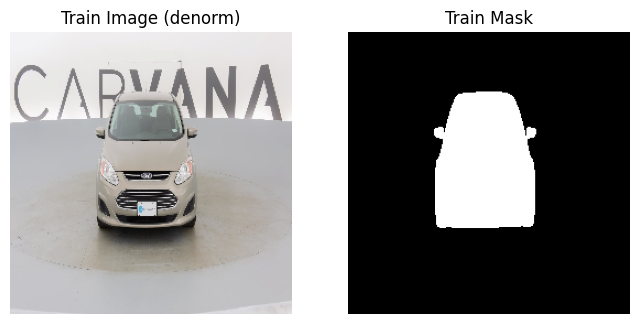

In [11]:
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

def denormalize(img):
    img = img.permute(1, 2, 0).cpu().numpy()
    img = (img * std + mean)
    return np.clip(img, 0, 1)

item = train_ds[0]
img_denorm = denormalize(item["image"])
mask = item["mask"].cpu().numpy()

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img_denorm)
plt.title("Train Image (denorm)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask, cmap="gray")
plt.title("Train Mask")
plt.axis("off")
plt.show()

# UNet

In [12]:
class SimpleUNet(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()

        self.enc1 = self._block(3, 64)
        self.enc2 = self._block(64, 128)
        self.enc3 = self._block(128, 256)
        self.enc4 = self._block(256, 512)
        self.pool = nn.MaxPool2d(2)


        self.bottleneck = self._block(512, 1024)
        self.up_bottleneck = nn.ConvTranspose2d(1024, 512, 2, stride=2)


        self.up4 = self._up_block(1024, 512)
        self.up3 = self._up_block(768, 256)
        self.up2 = self._up_block(384, 128)

        self.final_block = nn.Sequential(
            nn.Conv2d(192, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.final = nn.Conv2d(64, num_classes, 1)

    def _block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch), 
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch), 
            nn.ReLU(inplace=True),
        )
    
    def _up_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):

        x1 = self.enc1(x)        
        x2 = self.enc2(self.pool(x1))  
        x3 = self.enc3(self.pool(x2)) 
        x4 = self.enc4(self.pool(x3)) 


        b = self.bottleneck(self.pool(x4))   
        b_up = self.up_bottleneck(b)      

        d4 = torch.cat([b_up, x4], dim=1)    
        d4 = self.up4(d4)               

        d3 = torch.cat([d4, x3], dim=1)    
        d3 = self.up3(d3)                    

        d2 = torch.cat([d3, x2], dim=1)      
        d2 = self.up2(d2)                     

        d1 = torch.cat([d2, x1], dim=1)     
        d1 = self.final_block(d1)              

        return self.final(d1)                  

In [13]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

In [14]:
model = SimpleUNet().to(device)
model.apply(init_weights)

SimpleUNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, t

# Подбор гиперпараметров (ручной)

In [15]:
from itertools import product

In [16]:
configs = list(product(
    [1e-4, 3e-4, 5e-4],
    [8],                    
    ['bce', 'bce_dice']
))

In [17]:
results = []

In [18]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)

        inter = (probs * targets).sum(dim=(1, 2, 3))
        union = probs.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3))

        dice = (2 * inter + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

In [19]:
class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight

    def forward(self, logits, targets):
        return (
            self.bce_weight * self.bce(logits, targets) +
            self.dice_weight * self.dice(logits, targets)
        )

In [21]:
def compute_iou(pred, target, smooth=1e-6):
    if target.dim() == 3:
        target = target.unsqueeze(1)
    pred = torch.sigmoid(pred)
    inter = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) - inter
    return ((inter + smooth) / (union + smooth)).mean().item()

In [22]:
for lr, bs, loss_type in configs:
    print(f"\n lr={lr}, bs={bs}, loss={loss_type}")

    model = SimpleUNet().to(device)
    model.apply(init_weights)

    if loss_type == 'bce':
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = BCEDiceLoss()

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    for epoch in range(2):
        model.train()
        for batch in train_loader:
            X = batch["image"].to(device)
            y = batch["mask"].to(device).unsqueeze(1)

            optimizer.zero_grad()
            loss = criterion(model(X), y)
            loss.backward()
            optimizer.step()

    model.eval()
    val_iou = 0.0
    with torch.no_grad():
        for batch in val_loader:
            X = batch["image"].to(device)
            y = batch["mask"].to(device).unsqueeze(1)
            val_iou += compute_iou(model(X), y)

    avg_iou = val_iou / len(val_loader)

    results.append({
        'lr': lr,
        'loss': loss_type,
        'val_iou': avg_iou
    })

    print(f"- Val IoU: {avg_iou:.4f}")

    del model, optimizer
    torch.cuda.empty_cache()


 lr=0.0001, bs=8, loss=bce
- Val IoU: 0.9517

 lr=0.0001, bs=8, loss=bce_dice
- Val IoU: 0.9636

 lr=0.0003, bs=8, loss=bce
- Val IoU: 0.9099

 lr=0.0003, bs=8, loss=bce_dice
- Val IoU: 0.9628

 lr=0.0005, bs=8, loss=bce
- Val IoU: 0.9114

 lr=0.0005, bs=8, loss=bce_dice
- Val IoU: 0.8471


# Обучение

In [23]:
model = SimpleUNet().to(device)
model.apply(init_weights)

SimpleUNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, t

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm.auto import tqdm

d:\PythonProjects\CV\Laba1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
criterion = BCEDiceLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [26]:
for epoch in range(5):
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/5", leave=False):
        X = batch["image"].to(device, non_blocking=True)
        y = batch["mask"].to(device, non_blocking=True).unsqueeze(1)

        optimizer.zero_grad()
        pred = model(X)
        loss = criterion(pred, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        train_loss += loss.item()
    
    model.eval()
    val_iou = 0.0
    with torch.no_grad():
        for batch in val_loader:
            X = batch["image"].to(device)
            y = batch["mask"].to(device).unsqueeze(1)
            pred = model(X)
            val_iou += compute_iou(pred, y)
    avg_iou = val_iou / len(val_loader)
    
    print(f"Epoch {epoch+1} | Loss: {train_loss/len(train_loader):.4f} | Val mIoU: {avg_iou:.4f}")
    scheduler.step()


Epoch 1 | Loss: 0.0522 | Val mIoU: 0.9576


Epoch 2 | Loss: 0.0190 | Val mIoU: 0.9661


Epoch 3 | Loss: 0.0159 | Val mIoU: 0.9692


Epoch 4 | Loss: 0.0140 | Val mIoU: 0.9718


Epoch 5 | Loss: 0.0124 | Val mIoU: 0.9752


# Обобщающая способность

In [27]:
def evaluate_on_test(model, loader):
    model.eval()
    ious = []

    with torch.no_grad():
        for batch in loader:
            X = batch["image"].to(device)
            y = batch["mask"].to(device).unsqueeze(1)

            logits = model(X)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()

            inter = (preds * y).sum(dim=(1,2,3))
            union = preds.sum(dim=(1,2,3)) + y.sum(dim=(1,2,3)) - inter
            iou = (inter + 1e-6) / (union + 1e-6)

            ious.append(iou.cpu())

    ious = torch.cat(ious)

    return {
        "mean_iou": ious.mean().item(),
        "std_iou": ious.std().item(),
        "min_iou": ious.min().item(),
        "max_iou": ious.max().item(),
    }

In [28]:
test_metrics = evaluate_on_test(model, test_loader)

In [29]:
print("Test metrics:", test_metrics)

Test metrics: {'mean_iou': 0.9799647927284241, 'std_iou': 0.007536271587014198, 'min_iou': 0.9293110966682434, 'max_iou': 0.9900006055831909}


In [30]:
ious = []
with torch.no_grad():
    for batch in test_loader:
        X = batch["image"].to(device)
        y = batch["mask"].to(device).unsqueeze(1)

        pred = (torch.sigmoid(model(X)) > 0.5).float()

        inter = (pred * y).sum(dim=(1,2,3))
        union = pred.sum(dim=(1,2,3)) + y.sum(dim=(1,2,3)) - inter
        iou = (inter + 1e-6) / (union + 1e-6)
        ious.extend(iou.cpu().numpy())

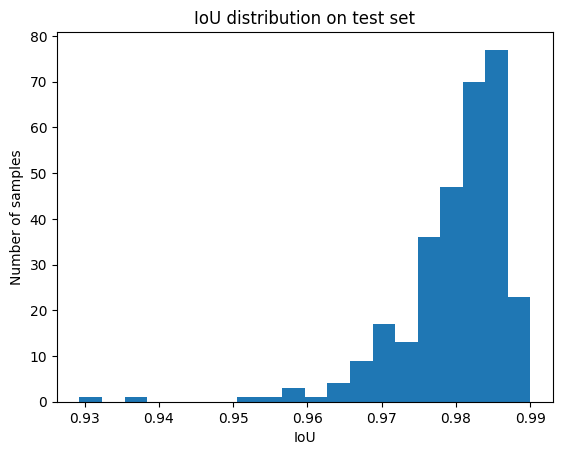

In [31]:
plt.hist(ious, bins=20)
plt.xlabel("IoU")
plt.ylabel("Number of samples")
plt.title("IoU distribution on test set")
plt.show()

In [32]:
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

def denormalize(t):
    t = t.permute(1,2,0).cpu().numpy()
    return np.clip(t * std + mean, 0, 1)

In [33]:
def visualize_test_predictions(model, loader, n=5):
    model.eval()
    batch = next(iter(loader))

    X = batch["image"].to(device)
    y = batch["mask"]

    with torch.no_grad():
        pred = (torch.sigmoid(model(X)) > 0.5).float()

    for i in range(min(n, X.size(0))):
        plt.figure(figsize=(12,4))

        plt.subplot(1,3,1)
        plt.imshow(denormalize(X[i]))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(y[i], cmap="gray")
        plt.title("GT Mask")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(pred[i,0].cpu(), cmap="gray")
        plt.title("Prediction")
        plt.axis("off")

        plt.show()

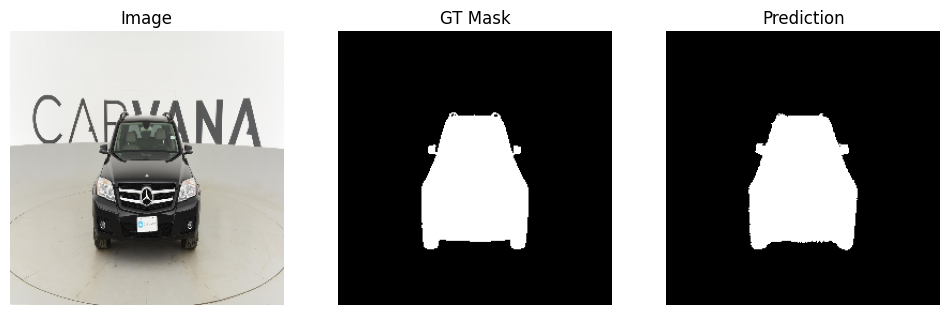

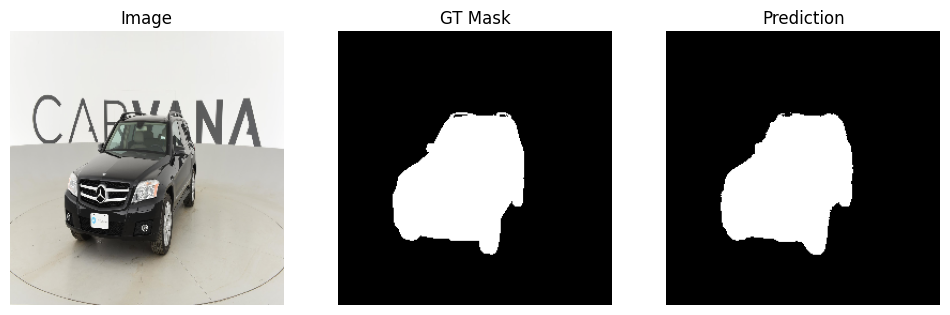

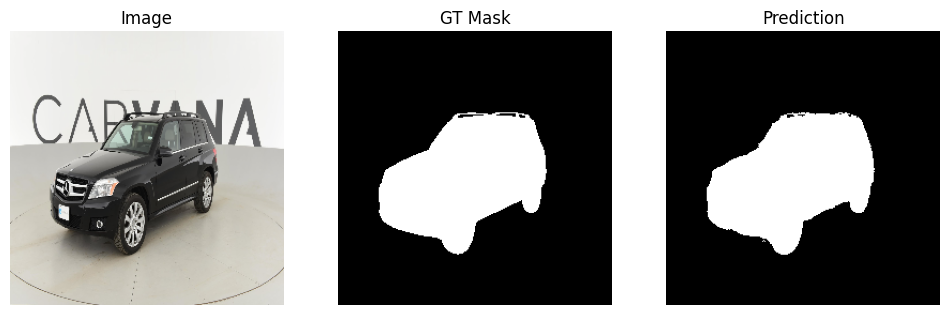

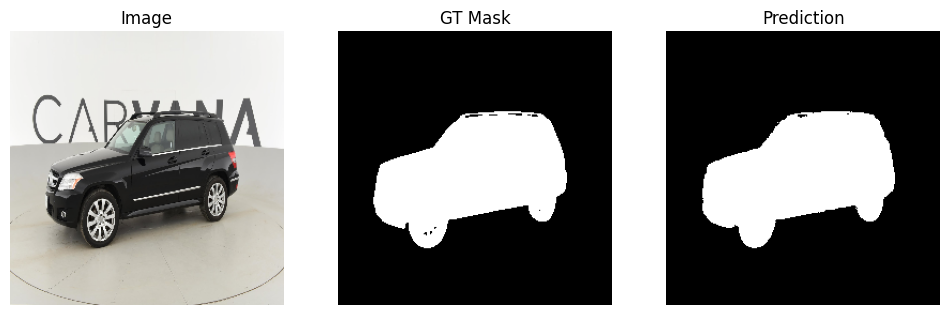

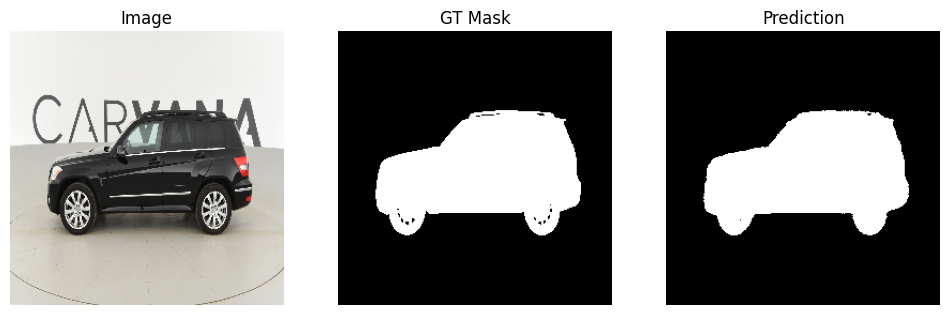

In [34]:
visualize_test_predictions(model, test_loader)